In [1]:
import numpy as np
from numpy.matlib import repmat
import pandas as pd
import EEG_Decoder.eeg_decoder as eeg_decoder
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

from mne.filter import filter_data
from scipy.signal import hilbert, chirp
from scipy.stats import ttest_1samp
import pingouin as pg

from utils import clean_behavior, setup_hyperplane_conds

from collections import Counter
%load_ext autoreload
%autoreload 2

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
np.random.seed(2023)

In [3]:
experiment_name = 'DATA/Preprocessed'
data_dir = f'../../{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
exp.behavior_files = sorted(list(exp.data_dir.glob('*.csv')))
exp.eyetracking_files = sorted(list(exp.data_dir.glob('*eyetracking.mat'))) # 009 has no eye tracking, only EOG

In [4]:
full_times = np.arange(-650, 1650, 2)
tois = np.arange(-250, 1250, 2)
times_bool = [True if (t in tois) else False for t in full_times]
censor_times = full_times >= 1250 # values to convert to 0 to prevent leak backwards

In [5]:
time_window = 25
time_step = 25
trial_bin_size = 1
n_splits = 100
group_dict = {}

wrangl = eeg_decoder.Wrangler(tois,time_window,time_step,trial_bin_size,n_splits,group_dict)
wrangl.t

array([-250, -226, -202, -178, -154, -130, -106,  -82,  -58,  -34,  -10,
         14,   38,   62,   86,  110,  134,  158,  182,  206,  230,  254,
        278,  302,  326,  350,  374,  398,  422,  446,  470,  494,  518,
        542,  566,  590,  614,  638,  662,  686,  710,  734,  758,  782,
        806,  830,  854,  878,  902,  926,  950,  974,  998, 1022, 1046,
       1070, 1094, 1118, 1142, 1166, 1190, 1214])

In [6]:
baseline_tps = (wrangl.samples >= -250) & (wrangl.samples <= -50)
baseline_tps.sum()

101

## Helpers

In [7]:
def makeBlockAssignment_CommonTrain(nBlocks,nBins,posLabels,Cond1Idx,Cond2Idx,minCnt=None):
    assert len(Cond1Idx)==len(Cond2Idx) and len(posLabels)==len(Cond1Idx)
    
    nTrials = len(Cond1Idx); 
    blocks = np.full((nTrials), np.nan)
    
    C1_posLabels = posLabels[Cond1Idx]
    C2_posLabels = posLabels[Cond2Idx]
    
    if minCnt is None: # use a min if its been given, otherwise find the min
        binCnt = np.full((2, nBins), np.nan)
        for b in range(nBins):
            binCnt[0,b] = np.sum(C1_posLabels == b+1)
            binCnt[1,b] = np.sum(C2_posLabels == b+1)

        minCnt = np.min(binCnt)
    nPerBin = int(np.floor(minCnt/nBlocks))
    
    
    for c in [1, 2]:
        pBin = C1_posLabels if c==1 else C2_posLabels

        tmp_nTrials = len(pBin)
        shuffBlocks = np.full(pBin.shape, np.nan)

        # shuffle trials
        shuffInd = np.arange(tmp_nTrials)
        np.random.shuffle(shuffInd)
        shuffBin = pBin[shuffInd] # shuffle trial order

        # take the 1st nPerBin x nBlocks trials for each position bin.
        for b in range(nBins):
            idx = np.where(shuffBin == b+1)[0]  # get index for trials belonging to the current bin
            idx = idx[:nPerBin*nBlocks]  # drop excess trials
            x = repmat(np.arange(1, nBlocks+1), 1, nPerBin)
            shuffBlocks[idx] = x # assign trials to blocks

        if c==1:
            C1_Blocks = np.full(C1_posLabels.shape, np.nan)
            C1_Blocks[shuffInd] = shuffBlocks
        elif c==2:
            C2_Blocks = np.full(C2_posLabels.shape, np.nan)
            C2_Blocks[shuffInd] = shuffBlocks


    ## regular blocks is just two condLabels combined
    blocks[Cond1Idx] = C1_Blocks
    blocks[Cond2Idx] = C2_Blocks
    nTrialsPerBlock = np.sum(blocks==1) # of trials per block
    nTrialsPerBlock_C1 = np.sum(blocks[Cond1Idx]==1)
    nTrialsPerBlock_C2 = np.sum(blocks[Cond2Idx]==1)
    
    return(blocks, nTrialsPerBlock, nTrialsPerBlock_C1, nTrialsPerBlock_C2, minCnt)

In [8]:
def MakeCircularBasis_Even_Bins(nBins, nChans, sinPower, x):
    prediction = np.sin(0.5*x)**sinPower
    prediction = np.roll(prediction, 4, axis=0)
    basisSet = np.full((nChans, nBins), np.nan)
    basisSet[0, :] = prediction
    for c in range(1, nChans):
        basisSet[c, :] = prediction = np.roll(prediction, 1, axis=0)
    return(basisSet)

In [9]:
def center_and_mean_CTF(ctf, shuffle=False):
    if shuffle:
        ctf = np.random.permutation(ctf) # shuffle rows
        
    ctf_aligned = ctf.copy()
    nrows = ctf.shape[0]
    for s in range(nrows):
        ctf_aligned[s, :] = np.roll(ctf[s, :], -s) # align the centers to the first column
        
    mean_ctf = np.mean(ctf_aligned, 0) # average across the rows (posLabels)
    
    return(np.roll(mean_ctf, int(np.ceil(nrows/2)))) # shift to center

def CTF_Slope(ctf):
    x = [1, 2, 3, 4, 5]
    y = [ctf[0], ctf[[1,7]].mean(), ctf[[2,6]].mean(), ctf[[3,5]].mean(), ctf[4]]
    return(np.polyfit(x, y, deg=1)[0]) # fit and get slope

In [10]:
def IEM_2cond(totalPower, posLabels, condLabels, times_bool, sinPower=25, nBins=8, nChans=8, nIter=100, nBlocks=3, freq_bounds=[8, 12], time = tois, Fs=500, wrangl=wrangl, init_minCnt=None):
    # ARGUMENTS
    # totalPower = Alpha power of EEG data of shape nTrials, nElectrodes, nTimePoints
    # posLabels = list of spatial positions (in terms of bin number) for each trial
    # condLabels = list of condition labels (1 or 2) for each trial
    # sinPower = power of the response function 
    # nBins = num location bins
    # nChans = num channels (cell popluations)
    # nIter =  num iterations (input to function)
    # nBlocks = num blocks for cross-validation
    # freq_bounds = frequency range to analyze 
    # nSamps = num time points of interest
    # Fs = Sampling rate of EEG

    nSamps = len(time)
    nTrials = len(posLabels)
    nElectrodes = totalPower.shape[1]
    
    x = np.linspace(0, 2*np.pi-2*np.pi/nBins, nBins)
    basisSet = MakeCircularBasis_Even_Bins(nBins, nChans, sinPower, x)
    
    Cond1Idx = condLabels==1
    Cond2Idx = condLabels==2
    
    # Preallocate Output Matrices
    tf_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    sl_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    
    # shuffled versions
    tf_total_Cond1_shuff = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond2_shuff = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    sl_total_Cond1_shuff = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond2_shuff = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    
    
    blocks = np.full((nTrials,nIter), np.nan)
    
    ## Filter and Organize Data into Blocks
    totalPower = np.squeeze(totalPower[:, :, np.where(times_bool)]) # subset to times-of-interest
    assert totalPower.shape[2]==nSamps
    
    ## create block assignments
    for i in range(nIter):
        (curr_blocks, nTrialsPerBlock, nTrialsPerBlock_C1, nTrialsPerBlock_C2, minCnt) = makeBlockAssignment_CommonTrain(nBlocks,nBins,posLabels,Cond1Idx,Cond2Idx,minCnt=init_minCnt);
        blocks[:,i] = curr_blocks
    
    print(f'min Bin Cnt: {minCnt}')
    tmpBlocks = blocks.copy()
    
    for i in range(nIter):
        curr_blocks = tmpBlocks[:,i]
        
        # Preallocate
        blockDat_total = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond1 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond2 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)

        labels = np.full((nBins*nBlocks), np.nan)
        blockNum = np.full((nBins*nBlocks), np.nan)
        c = np.full((nBins*nBlocks, nChans), np.nan)

        # Average data for each bin across blocks
        counter = 0
        for j in range(nBins):
            for k in range(nBlocks):
                # all data for training
                blockDat_total[counter,:,:] = np.mean(totalPower[(posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond1 Test
                blockDat_total_Cond1[counter,:,:] = np.mean(totalPower[(Cond1Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond2 Test
                blockDat_total_Cond2[counter,:,:] = np.mean(totalPower[(Cond2Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)

                # info
                labels[counter] = j
                blockNum[counter] = k
                c[counter,:] = basisSet[j,:]
                counter+=1

        # run IEM on each timepoint
        for t in range(len(wrangl.t)):
            time_window_idx = (wrangl.samples >= wrangl.t[t]) & (
                wrangl.samples < wrangl.t[t] + wrangl.time_window)
            
            dt = np.mean(blockDat_total[:, :, time_window_idx], 2)
            dt_Cond1 = np.mean(blockDat_total_Cond1[:,:,time_window_idx], 2)
            dt_Cond2 = np.mean(blockDat_total_Cond2[:,:,time_window_idx], 2)

            for b in range(nBlocks): # hold out each block as the test set, train on the other 2
                train_labels = labels[blockNum!=b]
                test_labels = labels[blockNum==b]

                C1 = c[blockNum!=b, :]
                B1 = dt[blockNum!=b, :]
                B2_Cond1 = dt_Cond1[blockNum==b, :]
                B2_Cond2 = dt_Cond2[blockNum==b, :]

                # fit model and record res
                channel_weights = np.linalg.lstsq(C1, B1, rcond=None)[0]
                recon1 = np.linalg.lstsq(channel_weights.T , B2_Cond1.T, rcond=None)[0].T
                ctf_Cond1 = center_and_mean_CTF(recon1)
                ctf_Cond1_shuff = center_and_mean_CTF(recon1, shuffle=True)
                
                recon2 = np.linalg.lstsq(channel_weights.T , B2_Cond2.T, rcond=None)[0].T
                ctf_Cond2 = center_and_mean_CTF(recon2)
                ctf_Cond2_shuff = center_and_mean_CTF(recon2, shuffle=True)
                
                tf_total_Cond1[i,t,b,:] = ctf_Cond1;
                tf_total_Cond1_shuff[i,t,b,:] = ctf_Cond1_shuff;
                tf_total_Cond2[i,t,b,:] = ctf_Cond2;
                tf_total_Cond2_shuff[i,t,b,:] = ctf_Cond2_shuff;
                
                # save the slopes
                sl_total_Cond1[i,t,b] = CTF_Slope(ctf_Cond1); 
                sl_total_Cond1_shuff[i,t,b] = CTF_Slope(ctf_Cond1_shuff);
                sl_total_Cond2[i,t,b] = CTF_Slope(ctf_Cond2);
                sl_total_Cond2_shuff[i,t,b] = CTF_Slope(ctf_Cond2_shuff);

                
    return {
        'tuneFuncs':{
            'Cond1': tf_total_Cond1,
            'Cond1_shuff': tf_total_Cond1_shuff,
            'Cond2': tf_total_Cond2,
            'Cond2_shuff': tf_total_Cond2_shuff,
        },
        'slope':{
            'Cond1': sl_total_Cond1,
            'Cond1_shuff': sl_total_Cond1_shuff,
            'Cond2': sl_total_Cond2,
            'Cond2_shuff': sl_total_Cond2_shuff
        },
        'minCnt': minCnt
    }

# clean up data

In [11]:
bins = np.arange(0, 361, 45)
bins

array([  0,  45,  90, 135, 180, 225, 270, 315, 360])

In [12]:
xdata_dict = {}
behavior_dict = {}
eye_dict = {}

for isub in range(exp.nsub):
    xdata,_ = exp.load_eeg(isub)
    xdata[:,:,censor_times] = 0 # censor timepoints to prevent bleeding backwards

    noArt_idx = exp.load_artifact_idx(isub)
    assert xdata.shape[0]==noArt_idx.sum()


    eye, eye_labels = exp.load_eyetracking(isub)


    behavior = pd.read_csv(exp.behavior_files[isub])
    behavior = clean_behavior(behavior, noArt_idx, isub)    
    assert len(behavior)==xdata.shape[0]

    # drop interruption trials for subs 4,5
    no_interruption_trials = (behavior.port_codes < 240).values
    behavior = behavior[no_interruption_trials].reset_index(drop=True)
    xdata = xdata[no_interruption_trials, :, :]
    eye = eye[no_interruption_trials, :, :]

    assert eye.shape[0]==len(behavior)

    # match nDots across loads
    behavior = behavior.query('total_nDots >= 24')
    xdata = xdata[behavior.index.values, :, :]
    eye = eye[behavior.index.values, :, :]
    behavior = behavior.reset_index(drop=True)

    # baseline eyemovements
    eye = eye[:,:,times_bool]  # clip off pre-baseline and post-delay
    baseline_mean = eye[:,:, baseline_tps].mean(2)
    eye = eye - baseline_mean[:,:, np.newaxis]
    eye = eye[:,:,wrangl.samples >=0].mean(2) # mean across post-stim period

    # extract x and y
    if 'GAZE-X' in eye_labels: # only 1 eye recorded
        x = np.squeeze(eye[:,np.where(eye_labels=='GAZE-X')[0]])
        y = np.squeeze(eye[:,np.where(eye_labels=='GAZE-Y')[0]])
    else:
        x = np.nanmean([np.squeeze(eye[:,np.where(eye_labels=='L-GAZE-X')[0]]), np.squeeze(eye[:,np.where(eye_labels=='R-GAZE-X')[0]])], 0)
        y = np.nanmean([np.squeeze(eye[:,np.where(eye_labels=='L-GAZE-Y')[0]]), np.squeeze(eye[:,np.where(eye_labels=='R-GAZE-Y')[0]])], 0)

    # convert to angle to find which bin eye was in
    angles = np.arctan2(y, x) * 180/np.pi # convert to degs
    angles = (angles + 360) % 360 # shift to 0-360 range
    assert((min(angles)>=0) and (max(angles)<=360))

    eye_bins = np.digitize(angles, bins, right=True)
    
    xdata_dict[isub] = np.abs(hilbert(filter_data(xdata.astype(np.float64), 500, 8, 12)))**2 # convert to alpha power
    behavior_dict[isub] = setup_hyperplane_conds(behavior)
    eye_dict[isub] = eye_bins



Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)



/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


# Visualization Helpers

In [13]:
hyperplane_conds = {
    0: 'SS1: Narrow',
    1: 'SS1: Broad',
    2: 'SS2: Overlap, Narrow',
    3: 'SS2: Overlap, Broad',
    4: 'SS2: Superset Overlap',
    5: 'SS2: Partial Overlap',
    6: 'SS2: No Overlap, Mixed',
    7: 'SS2: No Overlap, Narrow',
    8: 'SS2: No Overlap, Broad'
}

cond_load_map = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1} # mapping the conditions to loads

colormap = {
    0: 'royalblue',
    1: 'forestgreen',
    2: 'indigo',
    3: 'coral',
    4: 'orange',
    5: 'red',
    6: 'maroon',
    7: 'yellow',
    8: 'dodgerblue'
}

palette={hyperplane_conds[idx]: colormap[idx] for idx in range(9)}
palette

{'SS1: Narrow': 'royalblue',
 'SS1: Broad': 'forestgreen',
 'SS2: Overlap, Narrow': 'indigo',
 'SS2: Overlap, Broad': 'coral',
 'SS2: Superset Overlap': 'orange',
 'SS2: Partial Overlap': 'red',
 'SS2: No Overlap, Mixed': 'maroon',
 'SS2: No Overlap, Narrow': 'yellow',
 'SS2: No Overlap, Broad': 'dodgerblue'}

In [14]:
def make_slope_df(results, isub, cond, condname, time=wrangl.t):
    sub_slopes = pd.DataFrame()
    sub_slopes['time'] = time
    sub_slopes['Slope'] = results[isub]['slope'][cond].mean(0).mean(1)
    sub_slopes['PID'] = isub
    sub_slopes['condition'] = condname
    return(sub_slopes)

In [15]:
def make_CTF_df(results_dict, isub, cond, condname, wrangl=wrangl):
    sub_CTFs = pd.DataFrame()
    # mean across iterations, blocks, ignore the first 500ms before meaning across time
    sub_CTFs['Response'] = results_dict[isub]['tuneFuncs'][cond].mean(0).mean(1)[wrangl.t > 250, :].mean(0)
    sub_CTFs['Channel'] = np.arange(1,9)
    sub_CTFs['PID'] = isub
    sub_CTFs['condition'] = condname
    return(sub_CTFs)

In [16]:
def plot_results(results_dict, cond1, cond2, include_shuffle=False, figname=None, **kws):
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # SLOPE RESULTS
    slope_df_width = pd.DataFrame()
    for isub in results_dict.keys():
        sub_slopes_obs = pd.concat([make_slope_df(results_dict, isub, 'Cond1', cond1),
               make_slope_df(results_dict, isub, 'Cond2', cond2)])
        sub_slopes_obs['method'] = 'Observed'

        sub_slopes_shuff = pd.concat([make_slope_df(results_dict, isub, 'Cond1_shuff', cond1),
               make_slope_df(results_dict, isub, 'Cond2_shuff', cond2)])
        sub_slopes_shuff['method'] = 'Shuffled'

        slope_df_width = pd.concat([slope_df_width, sub_slopes_obs, sub_slopes_shuff])

    slope_df_width = slope_df_width.reset_index(drop=True)
    
    ax = sns.lineplot(x='time', y='Slope', hue='condition', style='method', data=slope_df_width, ax=axes[0], **kws)
    _ = ax.axhline(y=0, color='k', linestyle='--', linewidth=3)
    # plt.show()
    # plt.close()
    
    # SLOPE DIFFERENCE
    difference_df = slope_df_width.query(f'condition=="{cond1}"')[['time', 'Slope', 'PID']].reset_index(drop=True).sub(slope_df_width.query(f'condition=="{cond2}"')[['time', 'Slope', 'PID']].reset_index(drop=True))
    # assertions that the subtractions happened at the same time, subject
    all(difference_df.time.unique()==0)
    all(difference_df.PID.unique()==0)
    # replace with useful values 
    difference_df.time = slope_df_width.query(f'condition=="{cond1}"').time.values
    difference_df.PID = slope_df_width.query(f'condition=="{cond1}"').PID.values
    difference_df['method'] = slope_df_width.query(f'condition=="{cond1}"').method.values

    ax = sns.lineplot(x='time', y='Slope', style='method', data=difference_df, ax=axes[1])
    _ = ax.axhline(y=0, color='k', linestyle='--', linewidth=3)
    plt.show()
    plt.close()
    
    # CTF RESULTS - separate figure
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    CTF_df = pd.DataFrame()
    for isub in results_dict.keys():
        sub_CTFs_obs = pd.concat([make_CTF_df(results_dict, isub, 'Cond1', cond1),
               make_CTF_df(results_dict, isub, 'Cond2', cond2)])
        sub_CTFs_obs['method'] = 'Observed'
        
        CTF_df = pd.concat([CTF_df, sub_CTFs_obs])

        if include_shuffle:
            sub_CTFs_shuff = pd.concat([make_CTF_df(results_dict, isub, 'Cond1_shuff', cond1),
                   make_CTF_df(results_dict, isub, 'Cond2_shuff', cond2)])
            sub_CTFs_shuff['method'] = 'Shuffled'

            CTF_df = pd.concat([CTF_df, sub_CTFs_shuff])

    CTF_df = CTF_df.reset_index(drop=True)
    
    wraparound = CTF_df.query('Channel==1').copy()
    wraparound['Channel'] = 9
    CTF_df = pd.concat([CTF_df, wraparound]).reset_index(drop=True)
    if include_shuffle:
        ax = sns.lineplot(x='Channel', y='Response', hue='condition', style='method', data=CTF_df, err_style='bars', ax=axes, **kws)
    else:
        ax = sns.lineplot(x='Channel', y='Response', hue='condition', data=CTF_df, err_style='bars', ax=axes, linewidth=3, **kws)
    ax.set_xticks(np.arange(1, 10))
    ax.set_xticklabels(np.linspace(-180, 180, 9))
    if figname is not None:
        plt.tight_layout()
        plt.savefig(f'RawFigures/{figname}.svg')
    plt.show()
    plt.close()

In [17]:
def compare_delay_slopes(results_dict, cond1, cond2, alternative='two-sided', figname=None, **kws):

    # SLOPE RESULTS
    slope_df_width = pd.DataFrame()
    for isub in results_dict.keys():
        sub_slopes_obs = pd.concat([make_slope_df(results_dict, isub, 'Cond1', cond1),
               make_slope_df(results_dict, isub, 'Cond2', cond2)])
        sub_slopes_obs['method'] = 'Observed'

        sub_slopes_shuff = pd.concat([make_slope_df(results_dict, isub, 'Cond1_shuff', cond1),
               make_slope_df(results_dict, isub, 'Cond2_shuff', cond2)])
        sub_slopes_shuff['method'] = 'Shuffled'

        slope_df_width = pd.concat([slope_df_width, sub_slopes_obs, sub_slopes_shuff])

    slope_df_width = slope_df_width.reset_index(drop=True)


    summary = slope_df_width.query('(time > 250) & (time <= 1150) & (method=="Observed")').groupby(['PID', 'condition']).mean().reset_index()
    ax = sns.barplot(x='condition', y='Slope', data=summary, **kws)
    ax.set_ylim([0, .125])
    ax.set_yticks(np.arange(0, .125, .025))
    ax.set_yticklabels(np.round(np.arange(0, .125, .025), 3))
    
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    
    if figname is not None:
        plt.tight_layout()
        plt.savefig(f'RawFigures/{figname}_bar.svg')
    plt.show()
    diffs = summary.query(f'condition=="{cond1}"')['Slope'].values - summary.query(f'condition=="{cond2}"')['Slope'].values
    _ = sns.barplot(x=diffs)
    plt.show()
    plt.close()

    print(ttest_1samp(diffs, popmean=0, alternative=alternative))
    print(pg.ttest(x=diffs, y=0, alternative=alternative))
    
    # ax = sns.barplot(x='condition', y='Slope', data=summary, order=[cond1, cond2], ci=None, alpha=.8, **kws)
    # ax = sns.lineplot(x='condition', y='Slope', data=summary, sort=False, units='PID', estimator=None, color='k', alpha=.5, **kws)
    # ax = sns.stripplot(x='condition', y='Slope', data=summary, jitter=False, order=[cond1, cond2], hue='condition', s=10, edgecolor='k', linewidth=1, **kws)

    ax = sns.barplot(x='condition', y='Slope', data=summary, ci=None, alpha=.8, **kws)
    ax = sns.lineplot(x='condition', y='Slope', data=summary, units='PID', estimator=None, color='k', alpha=.5, **kws)
    ax = sns.stripplot(x='condition', y='Slope', data=summary, jitter=False, hue='condition', s=10, edgecolor='k', linewidth=1, **kws)
    
    ax.set_ylim([0, .21])
    # ax.set_xlim([-.15, 1.15])
    ax.set_yticks(np.arange(0, .225, .05))
    # ax.set_yticklabels(np.round(np.arange(0, .2, .025), 3))

    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    _ = ax.set_xlabel('')

    if figname is not None:
        plt.tight_layout()
        plt.savefig(f'RawFigures/{figname}_lines.svg')
    plt.show()

# Set Size 1 vs Set Size 2, using eye locations as target bins

In [18]:
np.random.seed(2023)

In [19]:
ss_eye_results = {}
for isub in range(exp.nsub):
    xdata = xdata_dict[isub]
    
    posLabels = eye_dict[isub]
    
    behavior = behavior_dict[isub]
    condLabels = behavior.SetSize.values
    print(isub, Counter(condLabels))
    
    ss_eye_results[isub] = IEM_2cond(xdata, posLabels, condLabels, times_bool)

0 Counter({2: 697, 1: 459})
min Bin Cnt: 34.0
1 Counter({2: 753, 1: 488})
min Bin Cnt: 31.0
2 Counter({2: 693, 1: 462})
min Bin Cnt: 33.0
3 Counter({2: 651, 1: 462})
min Bin Cnt: 35.0
4 Counter({2: 712, 1: 484})
min Bin Cnt: 37.0
5 Counter({2: 706, 1: 522})
min Bin Cnt: 22.0
6 Counter({2: 565, 1: 371})
min Bin Cnt: 9.0
7 Counter({2: 755, 1: 516})
min Bin Cnt: 28.0
8 Counter({2: 665, 1: 433})
min Bin Cnt: 20.0
9 Counter({2: 705, 1: 474})
min Bin Cnt: 37.0
10 Counter({2: 703, 1: 468})
min Bin Cnt: 47.0
11 Counter({2: 626, 1: 417})
min Bin Cnt: 12.0
12 Counter({2: 747, 1: 499})
min Bin Cnt: 34.0
13 Counter({2: 708, 1: 465})
min Bin Cnt: 28.0
14 Counter({2: 747, 1: 536})
min Bin Cnt: 42.0
15 Counter({2: 627, 1: 431})
min Bin Cnt: 24.0
16 Counter({2: 643, 1: 456})
min Bin Cnt: 33.0
17 Counter({2: 726, 1: 511})
min Bin Cnt: 19.0
18 Counter({2: 737, 1: 490})
min Bin Cnt: 28.0
19 Counter({2: 715, 1: 486})
min Bin Cnt: 43.0
20 Counter({2: 713, 1: 450})
min Bin Cnt: 22.0
21 Counter({2: 748, 1: 5

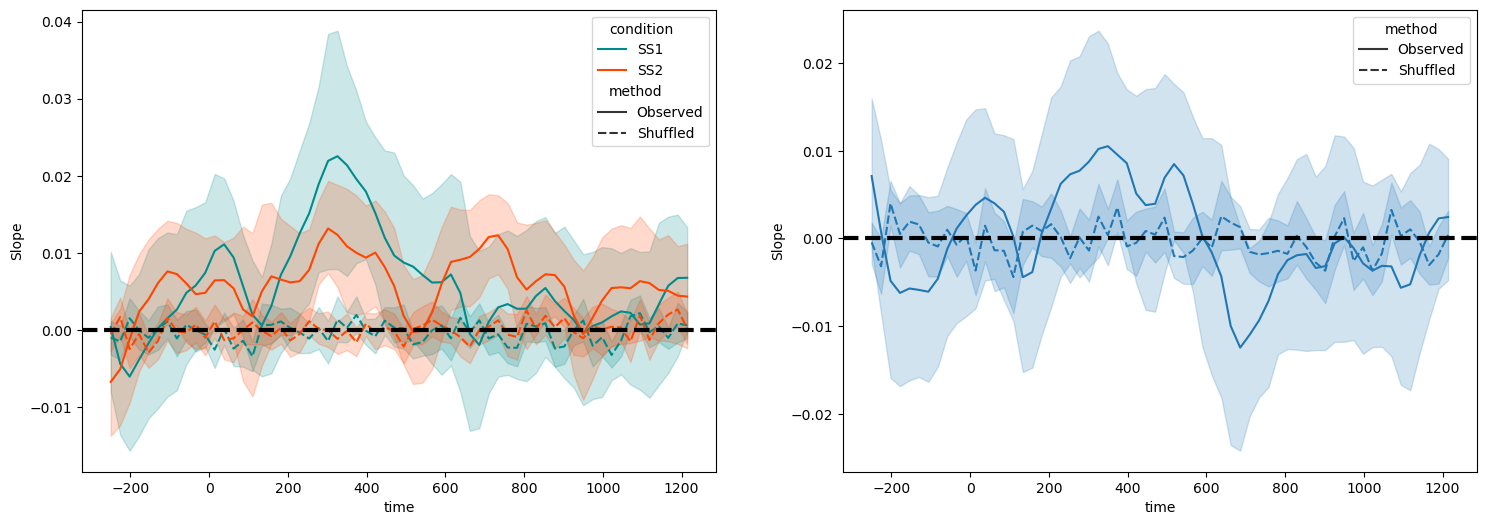

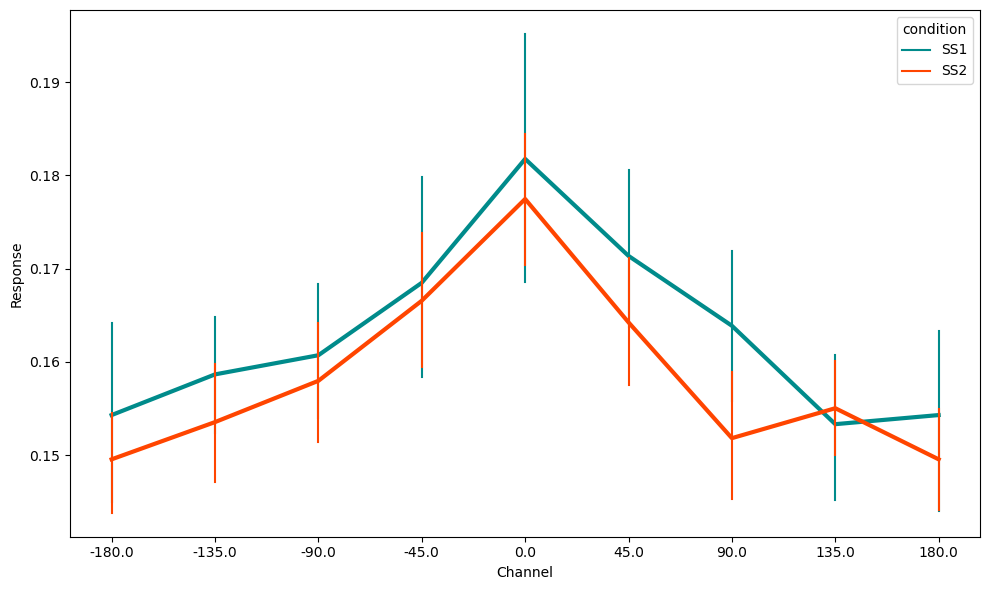

In [20]:
plot_results(ss_eye_results, 'SS1', 'SS2', figname='IEM_setSize_eyeGazeBins', palette={'SS1': 'darkcyan', 'SS2': 'orangered'})

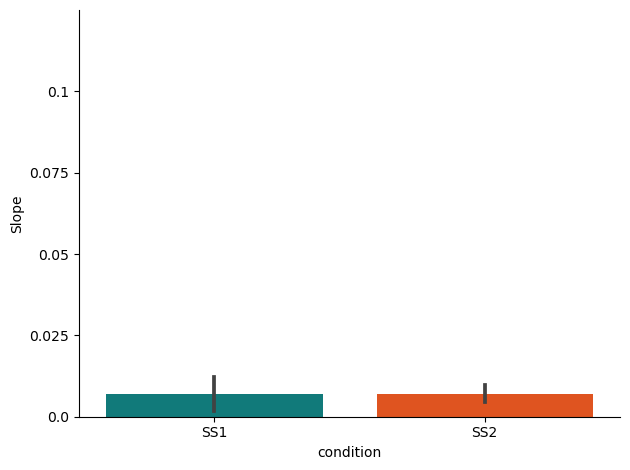

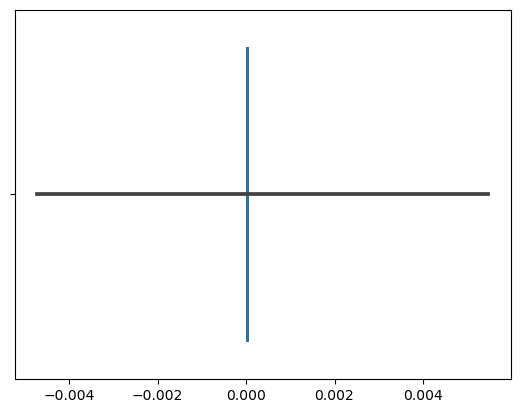

TtestResult(statistic=0.024772151102016915, pvalue=0.9804600306669421, df=22)
               T  dof alternative    p-val          CI95%   cohen-d   BF10  \
T-test  0.024772   22   two-sided  0.98046  [-0.01, 0.01]  0.005165  0.219   

           power  
T-test  0.050064  


/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_21721/938902906.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='condition', y='Slope', data=summary, ci=None, alpha=.8, **kws)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_21721/938902906.py:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x='condition', y='Slope', data=summary, units='PID', estimator=None, color='k', alpha=.5, **kws)


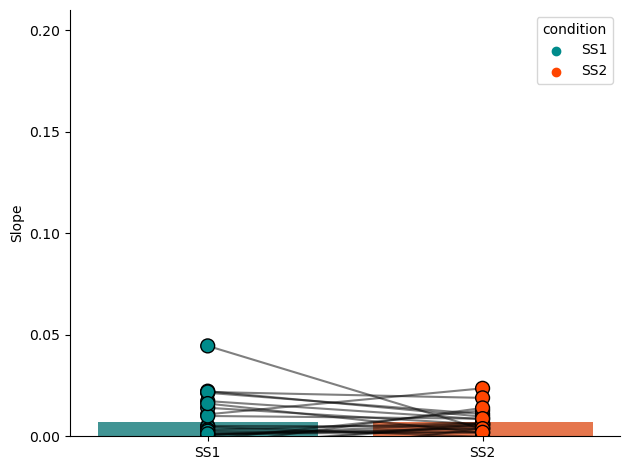

In [21]:
compare_delay_slopes(ss_eye_results, 'SS1', 'SS2', alternative='two-sided', figname='IEM_setSize_eyeGazeBins', palette={'SS1': 'darkcyan', 'SS2': 'orangered'})

# Set Size 1 vs Set Size 2 using target bins, but matched trial counts

In [22]:
np.random.seed(2023)

In [23]:
ss_results = {}
for isub in range(exp.nsub):
    xdata = xdata_dict[isub]
    behavior = behavior_dict[isub]
    
    posLabels = behavior.targetBin.values        
    condLabels = behavior.SetSize.values
    print(isub, Counter(condLabels))
    
    ss_results[isub] = IEM_2cond(xdata, posLabels, condLabels, times_bool, init_minCnt=ss_eye_results[isub]['minCnt'])

0 Counter({2: 697, 1: 459})
min Bin Cnt: 34.0
1 Counter({2: 753, 1: 488})
min Bin Cnt: 31.0
2 Counter({2: 693, 1: 462})
min Bin Cnt: 33.0
3 Counter({2: 651, 1: 462})
min Bin Cnt: 35.0
4 Counter({2: 712, 1: 484})
min Bin Cnt: 37.0
5 Counter({2: 706, 1: 522})
min Bin Cnt: 22.0
6 Counter({2: 565, 1: 371})
min Bin Cnt: 9.0
7 Counter({2: 755, 1: 516})
min Bin Cnt: 28.0
8 Counter({2: 665, 1: 433})
min Bin Cnt: 20.0
9 Counter({2: 705, 1: 474})
min Bin Cnt: 37.0
10 Counter({2: 703, 1: 468})
min Bin Cnt: 47.0
11 Counter({2: 626, 1: 417})
min Bin Cnt: 12.0
12 Counter({2: 747, 1: 499})
min Bin Cnt: 34.0
13 Counter({2: 708, 1: 465})
min Bin Cnt: 28.0
14 Counter({2: 747, 1: 536})
min Bin Cnt: 42.0
15 Counter({2: 627, 1: 431})
min Bin Cnt: 24.0
16 Counter({2: 643, 1: 456})
min Bin Cnt: 33.0
17 Counter({2: 726, 1: 511})
min Bin Cnt: 19.0
18 Counter({2: 737, 1: 490})
min Bin Cnt: 28.0
19 Counter({2: 715, 1: 486})
min Bin Cnt: 43.0
20 Counter({2: 713, 1: 450})
min Bin Cnt: 22.0
21 Counter({2: 748, 1: 5

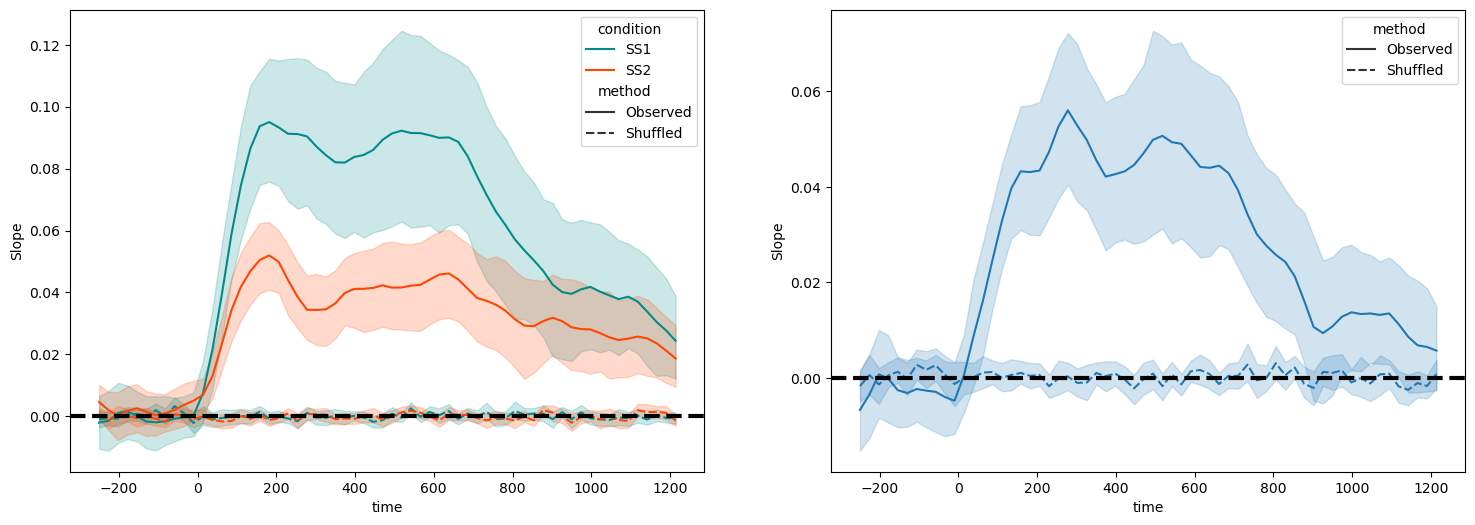

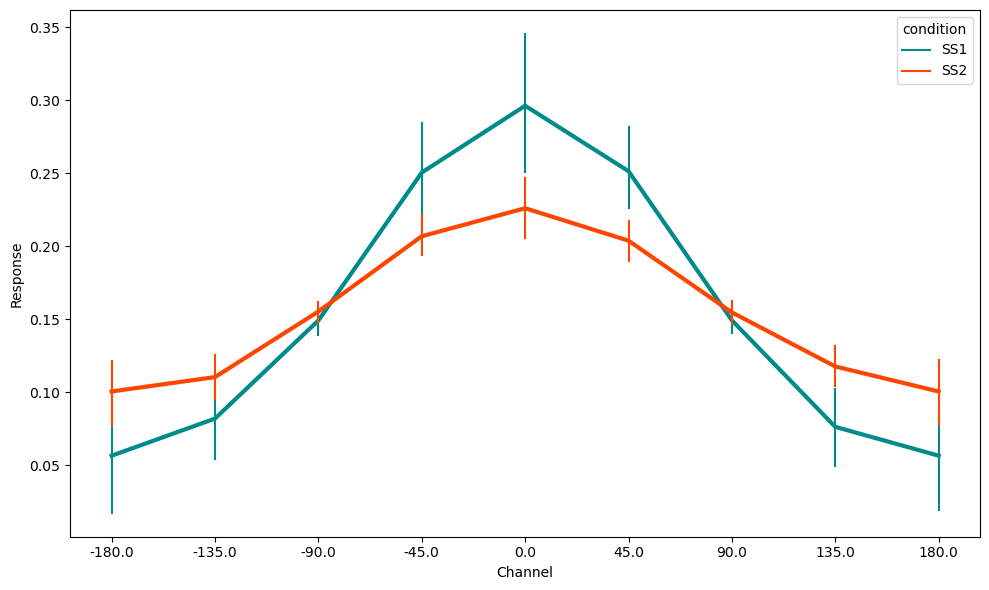

In [24]:
plot_results(ss_results, 'SS1', 'SS2', figname='IEM_setSize_eyeGazeBinsMatched', palette={'SS1': 'darkcyan', 'SS2': 'orangered'})

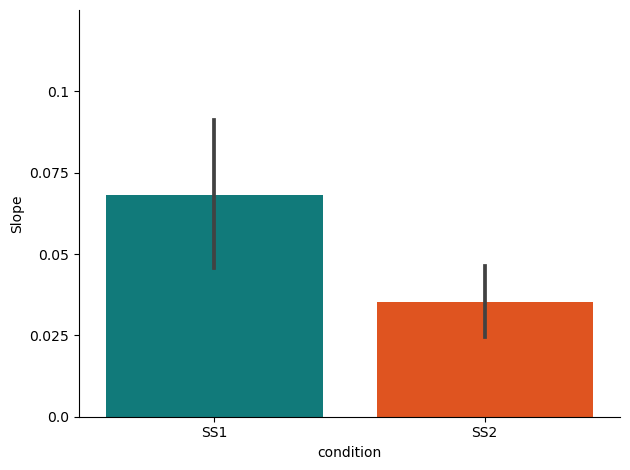

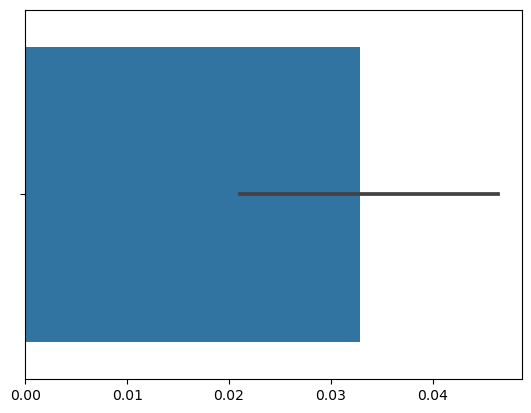

TtestResult(statistic=4.897732993778993, pvalue=6.750826167315465e-05, df=22)
               T  dof alternative     p-val         CI95%   cohen-d     BF10  \
T-test  4.897733   22   two-sided  0.000068  [0.02, 0.05]  1.021248  387.708   

           power  
T-test  0.996683  


/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_21721/938902906.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='condition', y='Slope', data=summary, ci=None, alpha=.8, **kws)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_21721/938902906.py:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x='condition', y='Slope', data=summary, units='PID', estimator=None, color='k', alpha=.5, **kws)


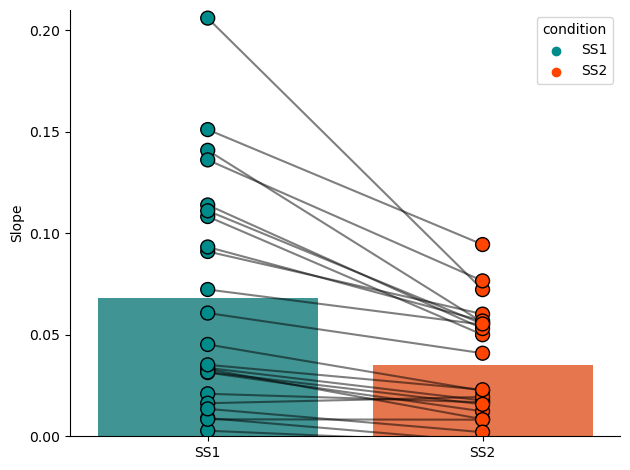

In [25]:
compare_delay_slopes(ss_results, 'SS1', 'SS2', alternative='two-sided', figname='IEM_setSize_eyeGazeBinsMatched', palette={'SS1': 'darkcyan', 'SS2': 'orangered'})

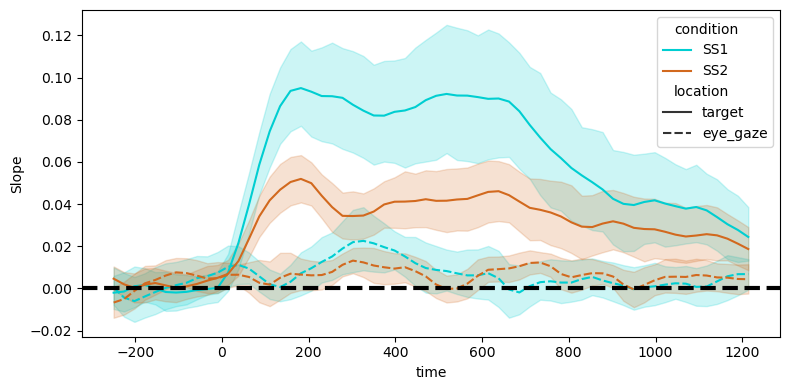

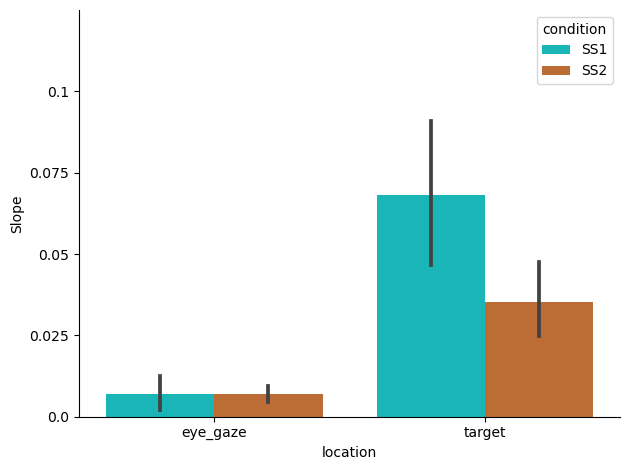

In [26]:
## Plot all slopes on one plot
# SLOPE RESULTS
slope_df_width = pd.DataFrame()
for isub in ss_results.keys():
    sub_slopes_obs = pd.concat([make_slope_df(ss_results, isub, 'Cond1', 'SS1'),
            make_slope_df(ss_results, isub, 'Cond2', 'SS2')])
    sub_slopes_obs['location'] = 'target'

    sub_slopes_shuff = pd.concat([make_slope_df(ss_eye_results, isub, 'Cond1', 'SS1'),
            make_slope_df(ss_eye_results, isub, 'Cond2', 'SS2')])
    sub_slopes_shuff['location'] = 'eye_gaze'

    slope_df_width = pd.concat([slope_df_width, sub_slopes_obs, sub_slopes_shuff])

slope_df_width = slope_df_width.reset_index(drop=True)

plt.figure(figsize=(8, 4))
ax = sns.lineplot(x='time', y='Slope', hue='condition', style='location', data=slope_df_width, palette={'SS1': 'darkturquoise', 'SS2': 'chocolate'})
_ = ax.axhline(y=0, color='k', linestyle='--', linewidth=3)
plt.tight_layout()
plt.savefig(f'RawFigures/SetSizeIEM_targetAndGaze_slopeAcrossTime.svg')
plt.show()
plt.close()

summary = slope_df_width.query('(time > 250) & (time <= 1150)').groupby(['PID', 'condition', 'location']).mean().reset_index()
ax = sns.barplot(x='location', y='Slope', hue='condition', data=summary, palette={'SS1': 'darkturquoise', 'SS2': 'chocolate'})

ax.set_ylim([0, .125])
ax.set_yticks(np.arange(0, .125, .025))
ax.set_yticklabels(np.round(np.arange(0, .125, .025), 3))

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.tight_layout()
plt.savefig(f'RawFigures/SetSizeIEM_targetAndGaze_slopeBars.svg')
plt.show()
plt.close()

# Remove participants with informative eyes

In [27]:
bad_eyes = pd.read_csv('informative_eye_subs.csv', index_col=0).index.values

for isub in bad_eyes:
    del ss_eye_results[isub]
    del ss_results[isub]

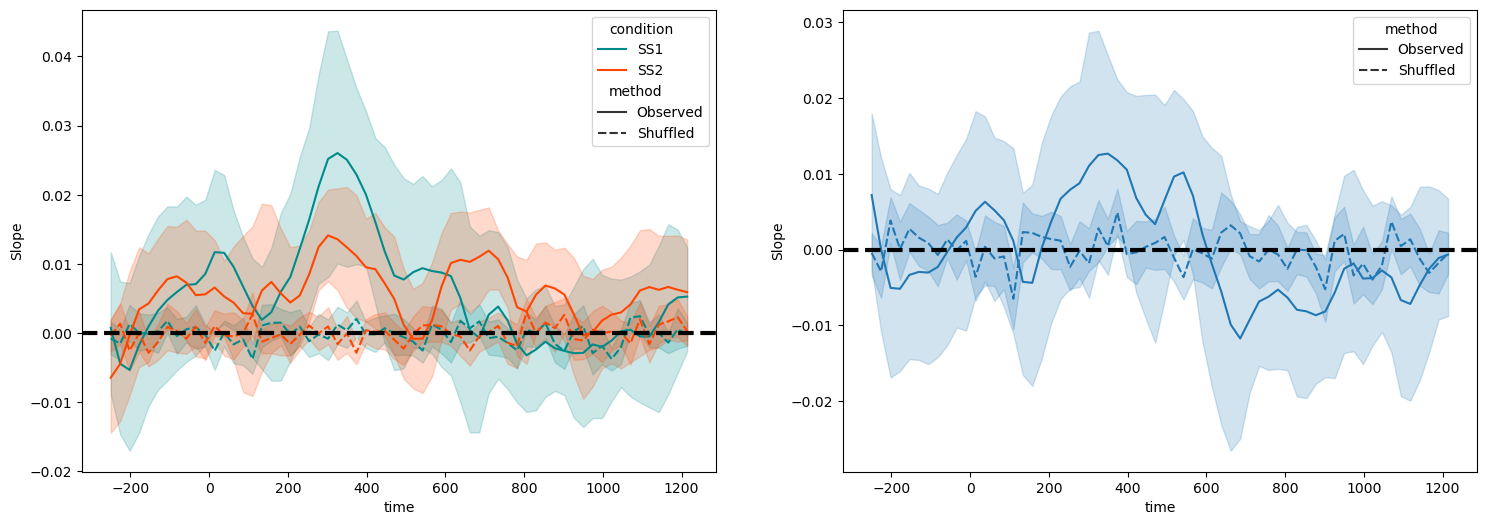

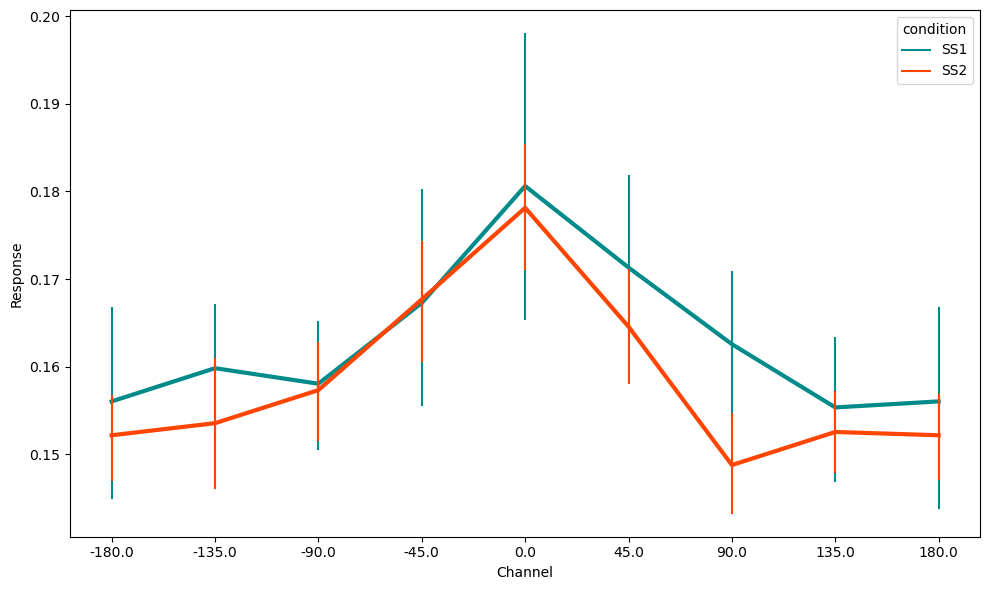

In [28]:
plot_results(ss_eye_results, 'SS1', 'SS2', figname='IEM_setSize_eyeGazeBins_noInformativeEyes', palette={'SS1': 'darkcyan', 'SS2': 'orangered'})

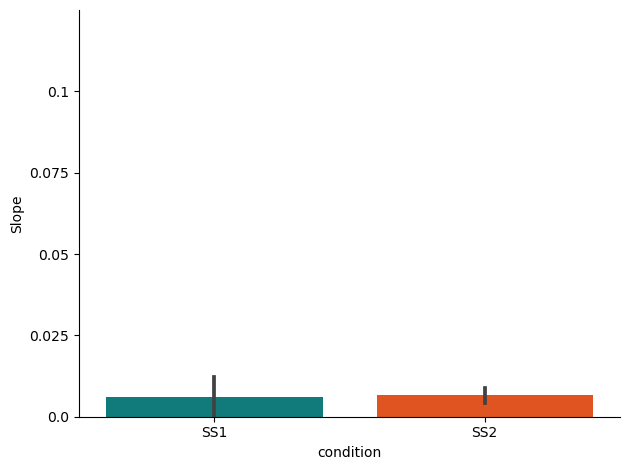

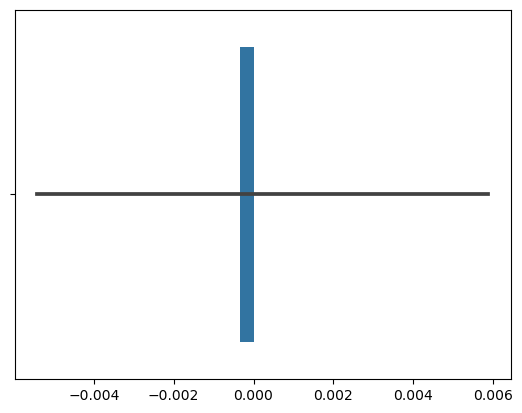

TtestResult(statistic=-0.10881454671759057, pvalue=0.9145534547106396, df=18)
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.108815   18   two-sided  0.914553  [-0.01, 0.01]  0.024964  0.239   

           power  
T-test  0.051219  


/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_21721/938902906.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='condition', y='Slope', data=summary, ci=None, alpha=.8, **kws)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_21721/938902906.py:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x='condition', y='Slope', data=summary, units='PID', estimator=None, color='k', alpha=.5, **kws)


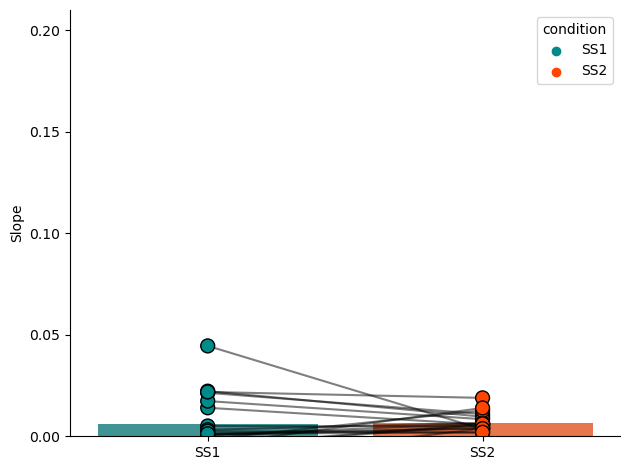

In [29]:
compare_delay_slopes(ss_eye_results, 'SS1', 'SS2', alternative='two-sided', figname='IEM_setSize_eyeGazeBins_noInformativeEyes', palette={'SS1': 'darkcyan', 'SS2': 'orangered'})

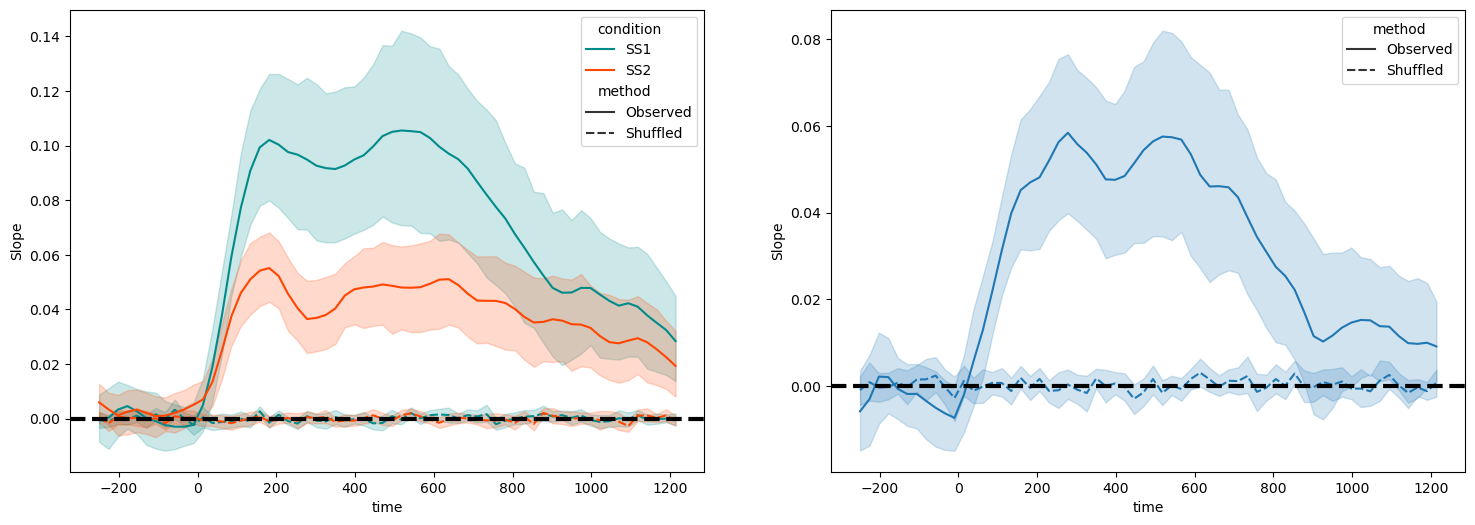

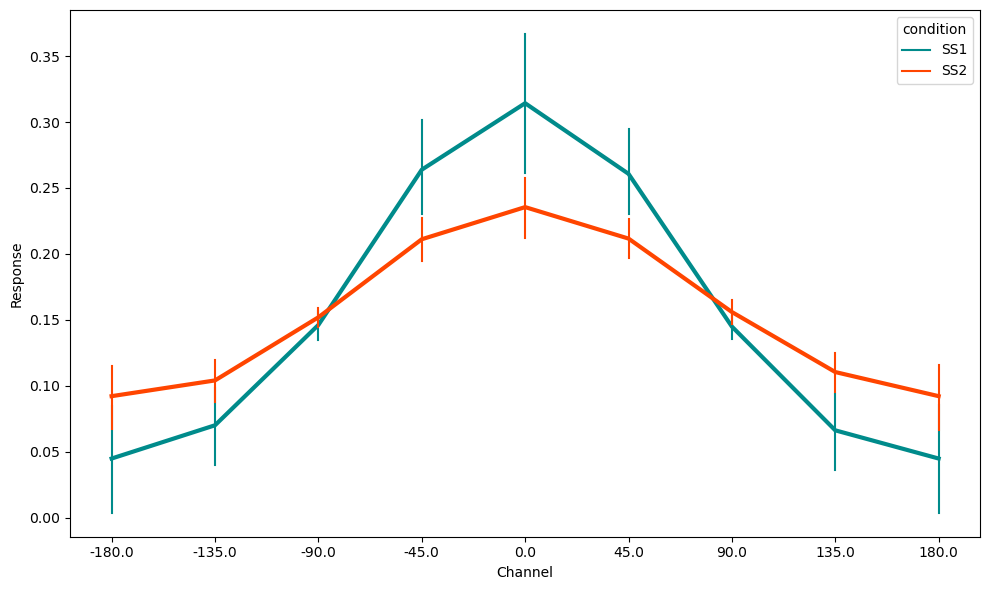

In [30]:
plot_results(ss_results, 'SS1', 'SS2', figname='IEM_setSize_eyeGazeBinsMatched_noInformativeEyes', palette={'SS1': 'darkcyan', 'SS2': 'orangered'})

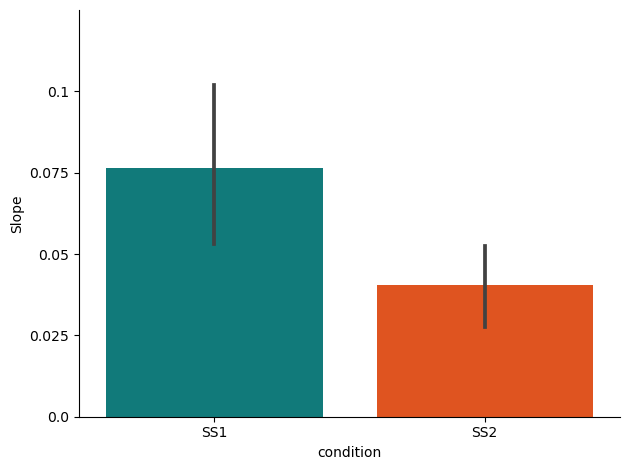

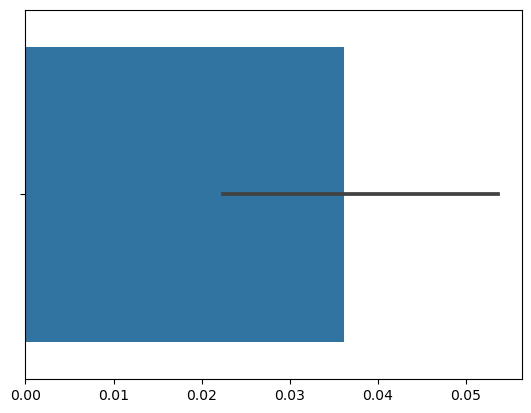

TtestResult(statistic=4.566986991159312, pvalue=0.00023898986254740532, df=18)
               T  dof alternative     p-val         CI95%   cohen-d     BF10  \
T-test  4.566987   18   two-sided  0.000239  [0.02, 0.05]  1.047739  129.463   

           power  
T-test  0.990665  


/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_21721/938902906.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='condition', y='Slope', data=summary, ci=None, alpha=.8, **kws)
/var/folders/g5/_50pp0f95mx6v6d1_3b33r700000gn/T/ipykernel_21721/938902906.py:46: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x='condition', y='Slope', data=summary, units='PID', estimator=None, color='k', alpha=.5, **kws)


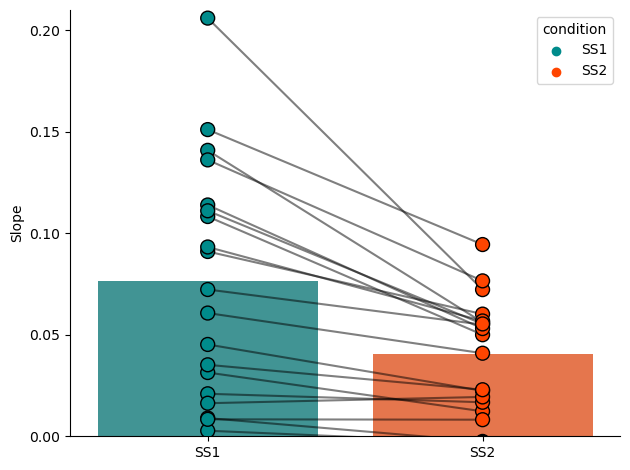

In [31]:
compare_delay_slopes(ss_results, 'SS1', 'SS2', alternative='two-sided', figname='IEM_setSize_eyeGazeBinsMatched_noInformativeEyes', palette={'SS1': 'darkcyan', 'SS2': 'orangered'})